In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)


import matplotlib.cm as cm

import matplotlib.pyplot as plt

from scipy import stats
import seaborn as sns

import sys
import inspect
import types

import scipy.cluster.hierarchy as spc

In [2]:
df_java = pd.read_csv('../metrics_nonezero_nonefork_v7.csv', index_col=0)

In [3]:
df_java = df_java.reset_index(drop=True)

In [4]:
df_java.shape

(14901, 42)

In [5]:
def prepare_df_metrics(df):
    df_java_log = df.copy()
    #   df_java_log.stars = np.log(df_java_log.stars)

    #   df_java_project_name = df_java_log.copy()
    #   df_java_project_name['metrics'] = 'project_name'
    #   df_java_project_name['follow'] = df_java_project_name.project_name_header_kw == 1

    df_java_description = df_java_log.copy()
    df_java_description['metrics'] = 'Description'
    df_java_description['follow'] = df_java_description.apply(
        lambda x: True if x.project_name_header_non_empty == 1 or x.description_header_kw == 1 else False, axis=1)

    df_java_content = df_java_log.copy()
    df_java_content['metrics'] = 'Table of Content'
    df_java_content['follow'] = df_java_content.content_header_kw == 1

    df_java_installation = df_java_log.copy()
    df_java_installation['metrics'] = 'Installation'
    df_java_installation['follow'] = df_java_installation.apply(lambda x: True if x.install_header_kw == 1 else False,
                                                                axis=1)

    df_java_usage = df_java_log.copy()
    df_java_usage['metrics'] = 'Usage'
    df_java_usage['follow'] = df_java_usage.apply(lambda
                                                      x: True if x.usage_header_kw == 1 or x.example_header_kw == 1 or x.document_header_kw == 1 or x.troubleshoot_header_kw == 1 else False,
                                                  axis=1)

    df_java_contributing = df_java_log.copy()
    df_java_contributing['metrics'] = 'Contributing'
    df_java_contributing['follow'] = df_java_contributing.apply(lambda x: True if x.contribut_header_kw == 1 else False,
                                                                axis=1)

    df_java_credit = df_java_log.copy()
    df_java_credit['metrics'] = 'Credit'
    df_java_credit['follow'] = df_java_credit.apply(
        lambda x: True if x.credit_header_kw == 1 or x.author_header_kw == 1 else False, axis=1)

    df_java_license = df_java_log.copy()
    df_java_license['metrics'] = 'License'
    df_java_license['follow'] = df_java_license.license_header_kw == 1

    return pd.concat([df_java_description, df_java_content, df_java_installation, df_java_usage, df_java_contributing,
                      df_java_credit, df_java_license], axis=0)


In [42]:
df_data_raw = df_java[df_java.isEnglishReadme==1]
df_data = prepare_df_metrics(df_data_raw)
df_data.groupby(['metrics','follow']).stars.describe()

count        mean          std  min  25%  50%    75%      max
metrics          follow                                                                 
Contributing     False   10974.0   43.237106   525.838431  1.0  1.0  2.0   6.00  39634.0
                 True      620.0  215.840323   962.950260  1.0  2.0  9.0  59.25  17357.0
Credit           False   11188.0   50.155613   561.973699  1.0  1.0  2.0   7.00  39634.0
                 True      406.0  116.167488   473.606944  1.0  2.0  5.0  27.75   5030.0
Description      False    6864.0   39.772145   545.511420  1.0  1.0  2.0   6.00  39634.0
                 True     4730.0   70.889852   578.120961  1.0  1.0  2.0   8.00  18653.0
Installation     False    9196.0   38.037734   522.586974  1.0  1.0  2.0   5.00  39634.0
                 True     2398.0  107.802335   679.020098  1.0  1.0  5.0  24.00  18653.0
License          False   10123.0   34.633508   497.552466  1.0  1.0  2.0   5.00  39634.0
                 True     1471.0  175.193746   862.839848  1.0  2.0  8.0  54.00  18653.0
Table of Content False   11417.0   48.874485   532.521187  1.0  1.0  2.0   7.00  39634.0
                 True      177.0  284.209040  1466.631688  1.0  1.0  4.0  22.00  13209.0
Usage            False    7979.0   25.966161   477.774481  1.0  1.0  2.0   4.00  39634.0
                 True     3615.0  110.960166   703.078137  1.0  1.0  4.0  21.00  18653.0

In [33]:
def gh_guidelines_description_stars(df):
    # Description
    t = df.copy()
    t['description'] = t.apply(
        lambda x: 1 if x.project_name_header_non_empty == 1 or x.description_header_kw == 1 else 0, axis=1)
    #   t['description'] = t.apply(lambda x: 1 if x.project_name_header_non_empty == 1 or x.description_header_kw == 1 or x.feature_header_kw == 1 else 0, axis = 1)
    #   t['description'] = t.apply(lambda x: 1 if x.description_header_kw == 1 else 0, axis = 1)
    #   return t.groupby('description').stars.describe()

    gb = t.groupby('description')
    values_per_group = {col_name: col for col_name, col in gb.stars}
    group_0 = values_per_group[0]
    group_1 = values_per_group[1]

    return pd.Series([group_0.size, group_1.size, np.mean(group_1) - np.mean(group_0),
                      stats.ranksums(group_0.values, group_1.values).pvalue], index=col_names)


def gh_guidelines_content_stars(df):
    # Content
    #   return df.groupby('content_header_kw').stars.describe()

    gb = df.groupby('content_header_kw')
    values_per_group = {col_name: col for col_name, col in gb.stars}
    group_0 = values_per_group[0]
    group_1 = values_per_group[1]

    return pd.Series([group_0.size, group_1.size, np.mean(group_1) - np.mean(group_0),
                      stats.ranksums(group_0.values, group_1.values).pvalue], index=col_names)


def gh_guidelines_installation_stars(df):
    # Installation
    t = df.copy()
    t['installation'] = t.apply(lambda x: 1 if x.install_header_kw == 1 else 0, axis=1)
    #   return t.groupby('installation').stars.describe()

    gb = t.groupby('installation')
    values_per_group = {col_name: col for col_name, col in gb.stars}
    group_0 = values_per_group[0]
    group_1 = values_per_group[1]

    return pd.Series([group_0.size, group_1.size, np.mean(group_1) - np.mean(group_0),
                      stats.ranksums(group_0.values, group_1.values).pvalue], index=col_names)


def gh_guidelines_usage_stars(df):
    # Usage
    t = df.copy()
    t['usage'] = t.apply(lambda
                             x: 1 if x.usage_header_kw == 1 or x.example_header_kw == 1 or x.document_header_kw == 1 or x.troubleshoot_header_kw == 1 else 0,
                         axis=1)
    #   return t.groupby('usage').stars.describe()

    gb = t.groupby('usage')
    values_per_group = {col_name: col for col_name, col in gb.stars}
    group_0 = values_per_group[0]
    group_1 = values_per_group[1]

    return pd.Series([group_0.size, group_1.size, np.mean(group_1) - np.mean(group_0),
                      stats.ranksums(group_0.values, group_1.values).pvalue], index=col_names)


def gh_guidelines_contributing_stars(df):
    # Contributing
    t = df.copy()
    t['contribution'] = t.apply(lambda x: 1 if x.contribut_header_kw == 1 else 0, axis=1)
    #   return t.groupby('contribution').stars.describe()

    gb = t.groupby('contribution')
    values_per_group = {col_name: col for col_name, col in gb.stars}
    group_0 = values_per_group[0]
    group_1 = values_per_group[1]

    return pd.Series([group_0.size, group_1.size, np.mean(group_1) - np.mean(group_0),
                      stats.ranksums(group_0.values, group_1.values).pvalue], index=col_names)


def gh_guidelines_credicts_stars(df):
    # Credicts
    t = df.copy()
    t['credits'] = t.apply(lambda x: 1 if x.credit_header_kw == 1 or x.author_header_kw == 1 else 0, axis=1)
    #   return t.groupby('credits').stars.describe()

    gb = t.groupby('credits')
    values_per_group = {col_name: col for col_name, col in gb.stars}
    group_0 = values_per_group[0]
    group_1 = values_per_group[1]

    return pd.Series([group_0.size, group_1.size, np.mean(group_1) - np.mean(group_0),
                      stats.ranksums(group_0.values, group_1.values).pvalue], index=col_names)


def gh_guidelines_license_stars(df):
    # License
    #   return df.groupby('license_header_kw').stars.describe()

    gb = df.groupby('license_header_kw')
    values_per_group = {col_name: col for col_name, col in gb.stars}
    group_0 = values_per_group[0]
    group_1 = values_per_group[1]

    return pd.Series([group_0.size, group_1.size, np.mean(group_1) - np.mean(group_0),
                      stats.ranksums(group_0.values, group_1.values).pvalue], index=col_names)


In [34]:
col_names = ['not_follow', 'follow', 'difference in mean', 'Wilcoxon $p$']

In [46]:
def plot_guidelines_table(data):
    return pd.DataFrame({ 
                'Description':gh_guidelines_description_stars(data),
                'Content':gh_guidelines_content_stars(data),
                'Installation':gh_guidelines_installation_stars(data),
                'Usage':gh_guidelines_usage_stars(data),
                'Contributing':gh_guidelines_contributing_stars(data),
                'Credicts':gh_guidelines_credicts_stars(data), 
                'License':gh_guidelines_license_stars(data)})

In [47]:
plot_guidelines_table(df_data_raw).T

,not_follow,follow,difference in mean,Wilcoxon $p$
Description,6864.0,4730.0,31.117707,3.073677e-04
Content,11417.0,177.0,235.334554,5.688149e-07
Installation,9196.0,2398.0,69.764601,2.431708e-122
Usage,7979.0,3615.0,84.994005,1.496760e-161
Contributing,10974.0,620.0,172.603217,6.975787e-68
Credicts,11188.0,406.0,66.011875,7.617424e-23
License,10123.0,1471.0,140.560238,5.557509e-147


In [48]:
def cliffsDelta(lst1, lst2, **dull):
    """Returns delta and true if there are more than 'dull' differences"""
    if not dull:
        dull = {'small': 0.147, 'medium': 0.33, 'large': 0.474}  # effect sizes from (Hess and Kromrey, 2004)
    m, n = len(lst1), len(lst2)
    lst2 = sorted(lst2)
    j = more = less = 0
    for repeats, x in runs(sorted(lst1)):
        while j <= (n - 1) and lst2[j] < x:
            j += 1
        more += j * repeats
        while j <= (n - 1) and lst2[j] == x:
            j += 1
        less += (n - j) * repeats
    d = (more - less) / (m * n)
    size = lookup_size(d, dull)
    return d, size


def lookup_size(delta: float, dull: dict) -> str:
    """
    :type delta: float
    :type dull: dict, a dictionary of small, medium, large thresholds.
    """
    delta = abs(delta)
    if delta < dull['small']:
        return 'negligible'
    if dull['small'] <= delta < dull['medium']:
        return 'small'
    if dull['medium'] <= delta < dull['large']:
        return 'medium'
    if delta >= dull['large']:
        return 'large'


def runs(lst):
    """Iterator, chunks repeated values"""
    for j, two in enumerate(lst):
        if j == 0:
            one, i = two, 0
        if one != two:
            yield j - i, one
            i = j
        one = two
    yield j - i + 1, two


# effect size


def gh_guidelines_description2(df):
    # Description
    t = df.copy()
    t['description'] = t.apply(
        lambda x: 1 if x.project_name_header_non_empty == 1 or x.description_header_kw == 1 else 0, axis=1)
    #   t['description'] = t.apply(lambda x: 1 if x.project_name_header_non_empty == 1 or x.description_header_kw == 1 or x.feature_header_kw == 1 else 0, axis = 1)
    #   t['description'] = t.apply(lambda x: 1 if x.description_header_kw == 1 else 0, axis = 1)
    return t.groupby('description')


def gh_guidelines_content2(df):
    t = df.copy()
    return t.groupby('content_header_kw')


def gh_guidelines_installation2(df):
    # Installation
    t = df.copy()
    t['installation'] = t.apply(lambda x: 1 if x.install_header_kw == 1 else 0, axis=1)
    return t.groupby('installation')


def gh_guidelines_usage2(df):
    # Usage
    t = df.copy()
    t['usage'] = t.apply(lambda
                             x: 1 if x.usage_header_kw == 1 or x.example_header_kw == 1 or x.document_header_kw == 1 or x.troubleshoot_header_kw == 1 else 0,
                         axis=1)
    return t.groupby('usage')


def gh_guidelines_contributing2(df):
    # Contributing
    t = df.copy()
    t['contribution'] = t.apply(lambda x: 1 if x.contribut_header_kw == 1 else 0, axis=1)
    return t.groupby('contribution')


def gh_guidelines_credicts2(df):
    # Credicts
    t = df.copy()
    t['credits'] = t.apply(lambda x: 1 if x.credit_header_kw == 1 or x.author_header_kw == 1 else 0, axis=1)
    return t.groupby('credits')


def gh_guidelines_license2(df):
    # License
    return df.groupby('license_header_kw')


In [49]:
cliffsDelta(gh_guidelines_description2(df_data).get_group(1).stars.values.tolist(),
            gh_guidelines_description2(df_data).get_group(0).stars.values.tolist())

(0.0393770913723345, 'negligible')

In [23]:
cliffsDelta(gh_guidelines_content2(df_data).get_group(1).stars.values.tolist(),
            gh_guidelines_content2(df_data).get_group(0).stars.values.tolist())

(0.21873269566792308, 'small')

In [24]:
cliffsDelta(gh_guidelines_installation2(df_data).get_group(1).stars.values.tolist(),
            gh_guidelines_installation2(df_data).get_group(0).stars.values.tolist())

(0.3114039773611546, 'small')

In [25]:
cliffsDelta(gh_guidelines_usage2(df_data).get_group(1).stars.values.tolist(),
            gh_guidelines_usage2(df_data).get_group(0).stars.values.tolist())

(0.31352213114057875, 'small')

In [26]:
cliffsDelta(gh_guidelines_contributing2(df_data).get_group(1).stars.values.tolist(),
            gh_guidelines_contributing2(df_data).get_group(0).stars.values.tolist())

(0.41494015179574006, 'medium')

In [27]:
cliffsDelta(gh_guidelines_credicts2(df_data).get_group(1).stars.values.tolist(),
            gh_guidelines_credicts2(df_data).get_group(0).stars.values.tolist())

(0.287014279902288, 'small')

In [28]:
cliffsDelta(gh_guidelines_license2(df_data).get_group(1).stars.values.tolist(),
            gh_guidelines_license2(df_data).get_group(0).stars.values.tolist())

(0.4159466703664572, 'medium')

In [29]:
gh_guidelines_description2(df_data)

In [7]:
figure3_order = df_data[df_data.follow==True].groupby('metrics')['stars'].median().sort_values(ascending=False).index.values

Text(0, 0.5, 'Stars')

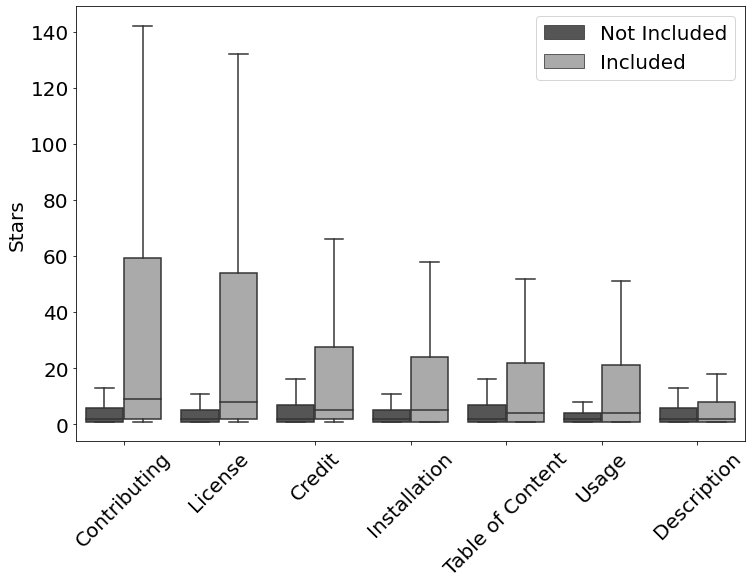

In [10]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(12, 8))
# sns.set(rc={'figure.figsize':(20,8),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white")
ax = sns.boxplot(x="metrics", y="stars", hue="follow", data=df_data, palette=sns.color_palette("gray", n_colors=2), showfliers=False, order=figure3_order)
# ax.legend_.remove()
plt.setp(ax.get_xticklabels(), rotation=45)
handles, labels = ax.get_legend_handles_labels()


plt.legend(handles[0:2], ['Not Included', 'Included'])
plt.xlabel('')
plt.ylabel('Stars')

# plt.savefig('this_is_a_path/figure3_sorted.pdf', format='pdf', bbox_inches = 'tight', pad_inches = 0.1)